# Fruit Detection

## Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

## Set constant size

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=35

## Import fruits data into tensorflow dataset object

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1212 files belonging to 6 classes.


In [4]:
class_names = dataset.class_names
class_names

['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

In [5]:
len(dataset)

38

In [6]:
38*32

1216

In [7]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 3 0 1 5 0 3 4 3 5 4 5 5 0 1 3 1 1 1 4 0 1 5 2 2 2 4 1 1 3 0 5]


Each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

In [8]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch[0].numpy())    # use .numpy image identify batch position
   # print(labels_batch.numpy())

[[[253.      253.      253.     ]
  [253.      253.      253.     ]
  [253.      253.      253.     ]
  ...
  [249.      249.      249.     ]
  [249.      249.      249.     ]
  [249.      249.      249.     ]]

 [[253.      253.      253.     ]
  [253.      253.      253.     ]
  [253.      253.      253.     ]
  ...
  [249.      249.      249.     ]
  [249.      249.      249.     ]
  [249.      249.      249.     ]]

 [[253.      253.      253.     ]
  [253.      253.      253.     ]
  [253.      253.      253.     ]
  ...
  [249.      249.      249.     ]
  [249.      249.      249.     ]
  [249.      249.      249.     ]]

 ...

 [[255.      255.      255.     ]
  [255.      255.      255.     ]
  [255.      255.      255.     ]
  ...
  [251.95312 250.97656 251.95312]
  [251.95312 250.97656 251.95312]
  [251.95312 250.97656 251.95312]]

 [[255.      255.      255.     ]
  [255.      255.      255.     ]
  [255.      255.      255.     ]
  ...
  [252.      251.      252.     ]
  [2

# Visualize some of the images from our dataset

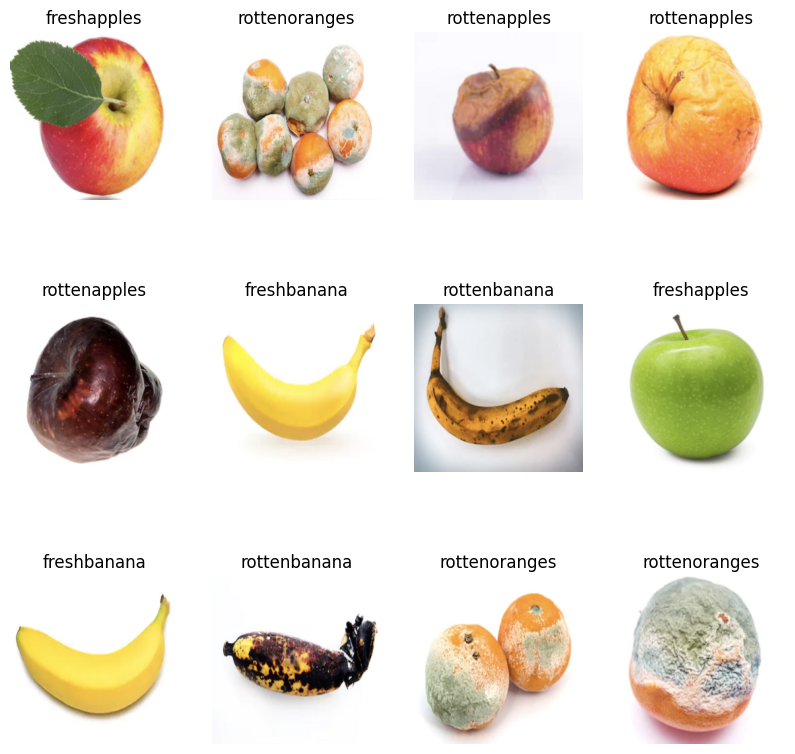

In [9]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:-

**Training**: Dataset to be used while training

**Validation**: Dataset to be tested against while training

**Test**: Dataset to be tested against after we trained a model

In [10]:
def get_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split+test_split+val_split)==1
    
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [11]:
train_ds, val_ds, test_ds = get_dataset(dataset)

In [12]:
len(train_ds)

30

In [13]:
len(val_ds)

3

In [14]:
len(test_ds)

5

# Cache, Shuffle, and Prefetch the Dataset

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

## Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./225)
])

# Data Augumentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data. It rorate the image in posssible way and that are used for model training.

In [17]:
data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

## Apply Data Augumentation on Training Data

In [18]:
train_ds = train_ds.map(
    lambda x,y: (data_augumentation(x, training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Deployment & Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

# Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [21]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=35,
)

Epoch 1/35
30/30 [==============================] - 36s 1s/step - loss: 3.2652 - accuracy: 0.2374 - val_loss: 1.4590 - val_accuracy: 0.4062
Epoch 2/35
30/30 [==============================] - 34s 1s/step - loss: 1.2981 - accuracy: 0.4697 - val_loss: 1.3160 - val_accuracy: 0.5000
Epoch 3/35
30/30 [==============================] - 34s 1s/step - loss: 1.0262 - accuracy: 0.6077 - val_loss: 0.9051 - val_accuracy: 0.6979
Epoch 4/35
30/30 [==============================] - 34s 1s/step - loss: 0.8432 - accuracy: 0.7040 - val_loss: 0.7026 - val_accuracy: 0.7188
Epoch 5/35
30/30 [==============================] - 34s 1s/step - loss: 0.6817 - accuracy: 0.7605 - val_loss: 0.4789 - val_accuracy: 0.8333
Epoch 6/35
30/30 [==============================] - 34s 1s/step - loss: 0.5828 - accuracy: 0.7835 - val_loss: 0.5070 - val_accuracy: 0.7917
Epoch 7/35
30/30 [==============================] - 34s 1s/step - loss: 0.5887 - accuracy: 0.7814 - val_loss: 0.6501 - val_accuracy: 0.7708
Epoch 8/35
30/30 [==

In [23]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 3s 282ms/step - loss: 0.3567 - accuracy: 0.8875


You can see above that we got 88.00% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [24]:
scores

[0.35674038529396057, 0.887499988079071]

Scores is just a list containing loss and accuracy value

# Plotting the accuracy and loss curves

In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 35, 'steps': 30}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are python list containing value of loss, accuracy etc at the end of each epoch

In [28]:
type(history.history['loss'])

list

In [29]:
len(history.history['loss'])

35

In [30]:
history.history['loss'][:5] # show loss for first 5 epochs

[3.2652292251586914,
 1.298075556755066,
 1.0261729955673218,
 0.8431945443153381,
 0.6817328929901123]

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

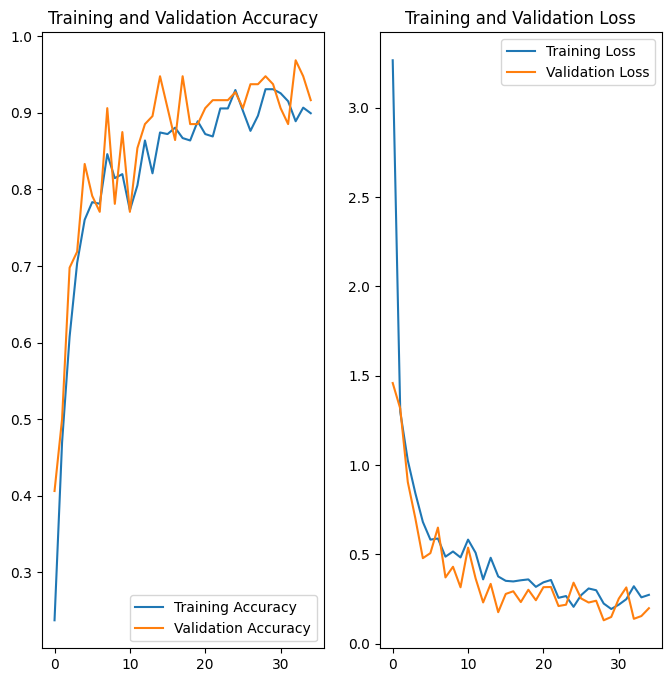

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: rottenapples
1/1 [==============================] - 0s 350ms/step
predicted label: rottenapples


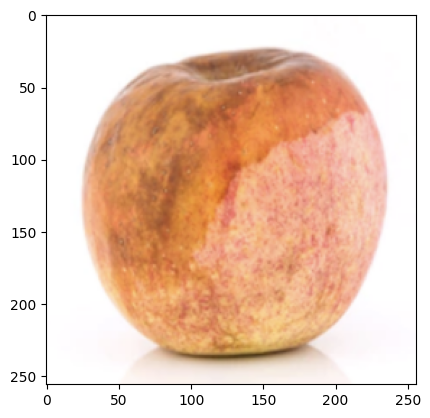

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Write a function for inference

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample imagesNow run inference on few sample images

1/1 [==============================] - 0s 36ms/step


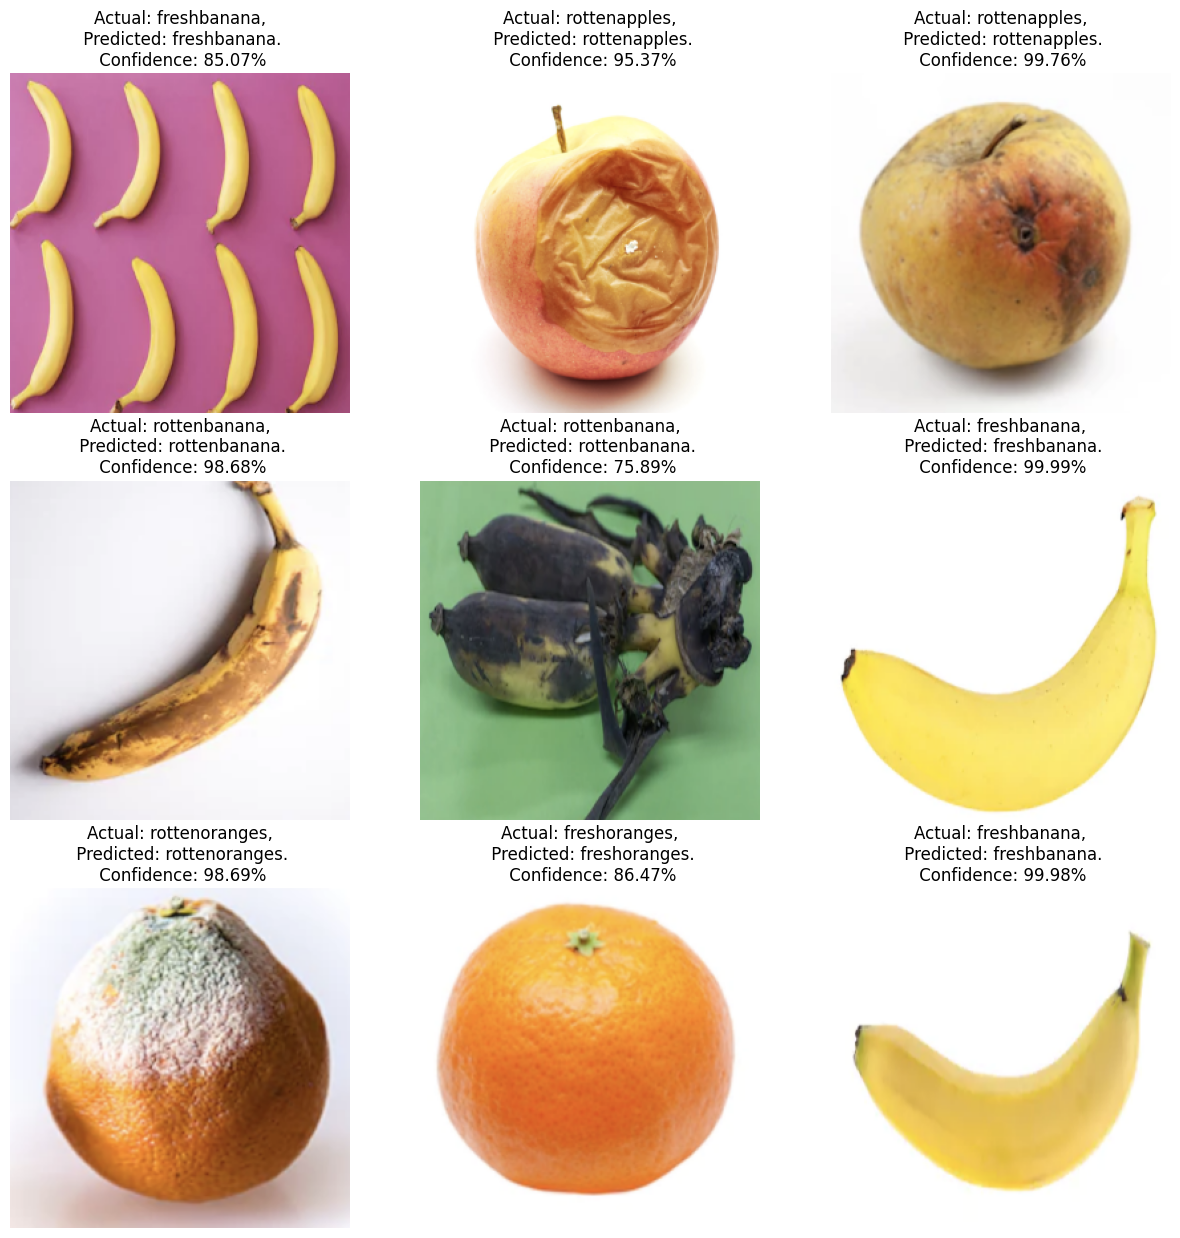

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model

We append the model to the list of models as a new version

In [37]:
import os
model_version=max([int(1) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2\assets


INFO:tensorflow:Assets written to: models/2\assets


In [38]:
model.save("models/fruits.h5")